# Loan preddiction 

### Importing libraries

In [599]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegressionCV 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import classification_report, confusion_matrix
warnings.filterwarnings('ignore')

# Colors
color = sns.color_palette('pastel')

In [2]:
df = pd.read_csv('data/train.csv')
df2 = pd.read_csv('data/test.csv')

In [3]:
#df.info()

In [4]:
# df2.info()

In [5]:
#df.describe()

In [6]:
#df2.describe()

In [7]:
#df.shape

In [8]:
# df2.shape

## Data Pre-processing

### Deleting Loan ID column

In [ ]:
df.drop('Loan_ID', axis = 1, inplace = True)

### Imputing missing values for df

In [9]:
df['Gender'] = df['Gender'].fillna(df['Gender'].mode(dropna=True)[0])
df['Married'] = df['Married'].fillna(df['Married'].mode(dropna=True)[0])
df['Dependents'] = df['Dependents'].fillna(df['Dependents'].mode(dropna=True)[0])
df['Self_Employed'] = df['Self_Employed'].fillna(df['Self_Employed'].mode(dropna=True)[0])

Let's analyze the numeric columns with missing values to know what imputacion tecnique use.

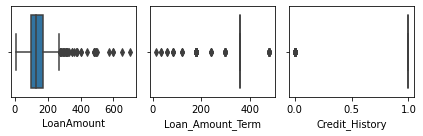

In [10]:
plt.figure(figsize = (6, 2))
plt.subplot(131)
sns.boxplot(df['LoanAmount'])
#.plot.box()
plt.subplot(132)
sns.boxplot(df['Loan_Amount_Term'])
plt.subplot(133)
sns.boxplot(df['Credit_History'])
plt.tight_layout()
plt.show()

In [11]:
df['LoanAmount'] = df['LoanAmount'].fillna(np.mean(df['LoanAmount']))
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode(dropna=True)[0])
df['Credit_History'] = df['Credit_History'].fillna(df['Credit_History'].mode(dropna=True)[0])

### Imputing missing values for df2

In [12]:
df2['Gender'] = df2['Gender'].fillna(df2['Gender'].mode(dropna=True)[0])
df2['Dependents'] = df2['Dependents'].fillna(df2['Dependents'].mode(dropna=True)[0])
df2['Self_Employed'] = df2['Self_Employed'].fillna(df2['Self_Employed'].mode(dropna=True)[0])

In [13]:
df2['LoanAmount'] = df2['LoanAmount'].fillna(np.mean(df2['LoanAmount']))
df2['Loan_Amount_Term'] = df2['Loan_Amount_Term'].fillna(df2['Loan_Amount_Term'].mode(dropna=True)[0])
df2['Credit_History'] = df2['Credit_History'].fillna(df2['Credit_History'].mode(dropna=True)[0])

## Looking for relations

### Gender

In [14]:
# Let's encode the target feature.
df['Loan_Status'] = df['Loan_Status'].replace({'Y': 1, 'N':0})

In [15]:
df.groupby('Gender')['Loan_Status'].mean()

Gender
Female    0.669643
Male      0.691235
Name: Loan_Status, dtype: float64

Althought there are more number of men than women, the percentage of granted loans is almost the same.

### Married

In [16]:
df.groupby('Married')['Loan_Status'].mean()

Married
No     0.629108
Yes    0.718204
Name: Loan_Status, dtype: float64

acording to the result, married person has more chance of obtaining a loan.

### Education

In [17]:
df.groupby('Education')['Loan_Status'].mean()

Education
Graduate        0.708333
Not Graduate    0.611940
Name: Loan_Status, dtype: float64

A graduate person has more opportunity to obtain a loan.

### Self Employed

In [18]:
df.groupby(['Self_Employed'])['Loan_Status'].mean()

Self_Employed
No     0.687970
Yes    0.682927
Name: Loan_Status, dtype: float64

The result for this feature don't say too much. Let's see if the combination of education and self employed give a better view. 

### Education - Self Employed

In [19]:
df.groupby(['Education', 'Self_Employed'])['Loan_Status'].mean()

Education     Self_Employed
Graduate      No               0.708434
              Yes              0.707692
Not Graduate  No               0.615385
              Yes              0.588235
Name: Loan_Status, dtype: float64

Here we have a better view, if somebody is graduated doesn't matter whether is self employed or not, the probability to obtain a loan is a little more than 70%. Unlike to somebody who is not graduated, if they are self employed have less chance to get a loan than if they aren't(yes, weird but true).

### Property Area

In [20]:
df.groupby('Property_Area')['Loan_Status'].mean()

Property_Area
Rural        0.614525
Semiurban    0.768240
Urban        0.658416
Name: Loan_Status, dtype: float64

As we can see, people that have properties in a semiurban area have more chance to obtain a loan, unlike that people with properties in a rural area, they have the less chance.

### Dependents

In [21]:
df.groupby('Dependents')['Loan_Status'].mean()

Dependents
0     0.686111
1     0.647059
2     0.752475
3+    0.647059
Name: Loan_Status, dtype: float64

Have 2 dependents give you a better opportunity to get a loan.

### Credit History

In [25]:
df.groupby('Credit_History')['Loan_Status'].mean()

Credit_History
0.0    0.078652
1.0    0.790476
Name: Loan_Status, dtype: float64

As we can see, have credit history increses our chance of obtaining a loan.

### Correlation between numeric columns and predictor variable

<AxesSubplot:>

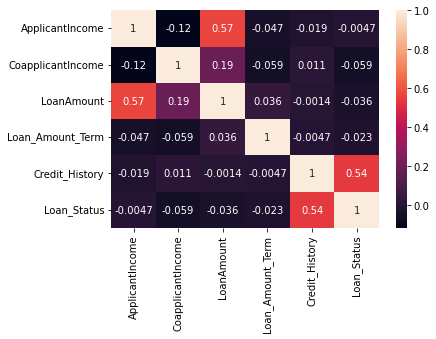

In [28]:
sns.heatmap(df.corr(), annot = True)

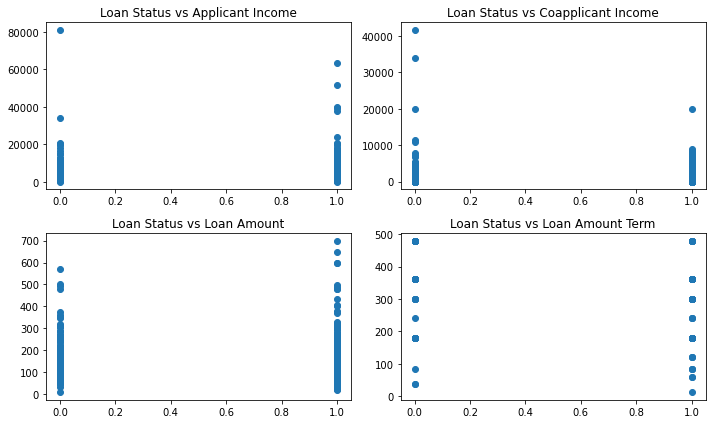

In [33]:
plt.figure(figsize=(10, 6))
plt.subplot(221)
plt.scatter(df['Loan_Status'], df['ApplicantIncome'])
plt.title('Loan Status vs Applicant Income')
plt.subplot(222)
plt.scatter(df['Loan_Status'], df['CoapplicantIncome'])
plt.title('Loan Status vs Coapplicant Income')
plt.subplot(223)
plt.scatter(df['Loan_Status'], df['LoanAmount'])
plt.title('Loan Status vs Loan Amount')
plt.subplot(224)
plt.scatter(df['Loan_Status'], df['Loan_Amount_Term'])
plt.title('Loan Status vs Loan Amount Term')
plt.tight_layout()
plt.show()

In [ ]:
Confirming the result of the pearson correlation, there's no a strong relationship between the features plotted above and target feature.

### Selecting features with a strong correlation.

In [590]:
features = ['Gender', 'Married', 'Education', 'Credit_History', 'Property_Area']

## Dividing predictor features and target feature

In [591]:
x = df[features]
y = df['Loan_Status']

### Split df into train and test sets

In [604]:
rskf = RepeatedStratifiedKFold()
for train_index, test_index in rskf.split(x, y):
    x_train, x_test = x.iloc[train_index], x.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

### Scale numeric features

In [578]:
qt = QuantileTransformer(output_distribution='normal')
x_train[['CoapplicantIncome']] = qt.fit_transform(x_train[['CoapplicantIncome']])

<AxesSubplot:xlabel='ApplicantIncome', ylabel='Density'>

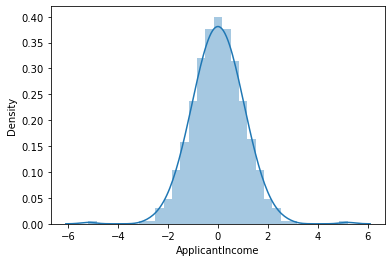

In [462]:
sns.distplot(x_train['ApplicantIncome'])

In [606]:
oh = OneHotEncoder(drop='first')
encode_feature = oh.fit_transform(x_train[['Gender', 'Married', 'Education', 'Property_Area']]).toarray()
encode_feature2 = oh.transform(x_test[['Gender', 'Married', 'Education', 'Property_Area']]).toarray()
encode_df = pd.DataFrame(encode_feature,  
                         columns = oh.get_feature_names(['Gender', 'Married', 'Education', 'Property_Area']),
                         index = x_train.index)
encode_df2 = pd.DataFrame(encode_feature2,  
                         columns = oh.get_feature_names(['Gender', 'Married', 'Education', 'Property_Area']),
                         index = x_test.index)

In [607]:
x_train = x_train.drop(['Gender', 'Married', 'Education', 'Property_Area'], axis = 1)
x_test = x_test.drop(['Gender', 'Married', 'Education', 'Property_Area'], axis = 1)
x_train = pd.concat([encode_df, x_train], axis = 1)
x_test = pd.concat([encode_df2, x_test], axis = 1)

,Gender,Married,Education,Credit_History,Property_Area
0,Male,No,Graduate,1.0,Urban
3,Male,Yes,Not Graduate,1.0,Urban
12,Male,Yes,Graduate,1.0,Urban
14,Male,Yes,Graduate,1.0,Urban
20,Male,Yes,Not Graduate,0.0,Urban
...,...,...,...,...,...
578,Male,Yes,Graduate,1.0,Rural
587,Female,No,Not Graduate,1.0,Semiurban
595,Male,No,Not Graduate,1.0,Rural
596,Male,Yes,Not Graduate,1.0,Rural


In [640]:
logist_reg = LogisticRegressionCV()
model = logist_reg.fit(x_train, y_train)
model.score(x_train, y_train)

0.8130081300813008

### Tuning hyperparameters

In [641]:
parameters = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
             'penalty': ['l1', 'l2', 'elasticnet'],
             'Cs': [100, 10, 1, 0.1, 0.01],
             'class_weight': ['balanced']}

In [642]:
rs = RandomizedSearchCV(logist_reg, param_distributions=parameters, cv = 10, scoring = 'f1').fit(x_train, y_train)
rs.score(x_train, y_train)

0.8523206751054854

In [643]:
print(rs.best_params_)
print(rs.best_score_)

{'solver': 'sag', 'penalty': 'l2', 'class_weight': 'balanced', 'Cs': 100}
0.8449484923934085


In [260]:
test = pd.DataFrame({'Gender': ['Female'], 
              'Married': ['No'],
              'Education': ['Graduate'], 
              'Self_Employed': ['No'],
              'Property_Area': ['Urban'], 
              'Credit_History': [0]})
test2 = pd.concat([pd.DataFrame(oh.transform(test[['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']]).toarray(), 
             columns = oh.get_feature_names(['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area'])), test.iloc[:, -1]], axis = 1)

,Gender_Male,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Property_Area_Semiurban,Property_Area_Urban,Credit_History
0,0.0,0.0,0.0,0.0,0.0,1.0,0


In [644]:
print(classification_report(y_test, rs.predict(x_test)))

              precision    recall  f1-score   support

           0       0.58      0.47      0.52        38
           1       0.78      0.85      0.81        84

    accuracy                           0.73       122
   macro avg       0.68      0.66      0.67       122
weighted avg       0.72      0.73      0.72       122



<AxesSubplot:>

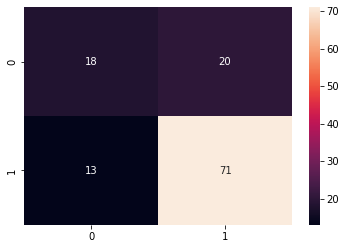

In [646]:
sns.heatmap(confusion_matrix(y_test, rs.predict(x_test)), annot = True)

In [648]:
!pip install imbalanced-learn

  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.2
    Uninstalling scikit-learn-0.24.2:
      Successfully uninstalled scikit-learn-0.24.2


In [663]:
# from imblearn.under_sampling import NearMiss
from sklearn.metrics import DistanceMetric

ImportError: cannot import name 'DistanceMetric' from 'sklearn.metrics' (C:\Users\pc\anaconda3\lib\site-packages\sklearn\metrics\__init__.py)

In [659]:
y_train.value_counts()

1    338
0    154
Name: Loan_Status, dtype: int64